In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=9d344b9cdf6e0b6aeab15427e606ac4821890455f87b46e3b9294583367943bc
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnull

# Khởi tạo Spark Session
spark = SparkSession.builder.appName("Do uong Phan tich").getOrCreate()

# Tải dữ liệu từ file CSV
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/BigData/Dataset/water_potability.csv", sep=';', header=True, inferSchema=True)

# Hiển thị cấu trúc dữ liệu
df.printSchema()

# Hiển thị một vài dòng dữ liệu đầu tiên
df.show(5)


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+-----------+-----------+-----------+-----------+-----------+------------+--------------+---------------+-----------+----------+
|         ph|   Hardness|     Solids|Chloramines|    Sulfate|Conductivity|Organic_carbon|Trihalomethanes|  Turbidity|Potability|
+-----------+-----------+-----------+-----------+-----------+------------+--------------+---------------+-----------+----------+
|       NULL|204.8904555|20791.31898|7.300211873|368.5164413| 564.3086542|   10.37978308|    86.99097046|2.963135381|         0|
|3.716080075|129.4229205|18630.05786|6.635245884|       NULL| 5

In [ ]:
# Hiển thị cấu trúc dữ liệu
df.printSchema()

# Kiểm tra dữ liệu thiếu
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

# Hiển thị một vài dòng dữ liệu
df.show()


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+

+-----------+-----------+-----------+------

In [ ]:
# Loại bỏ các hàng có giá trị thiếu
df_dropped = df.na.drop()

# Kiểm tra dữ liệu thiếu sau khi loại bỏ
df_dropped.select([count(when(isnull(c), c)).alias(c) for c in df_dropped.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



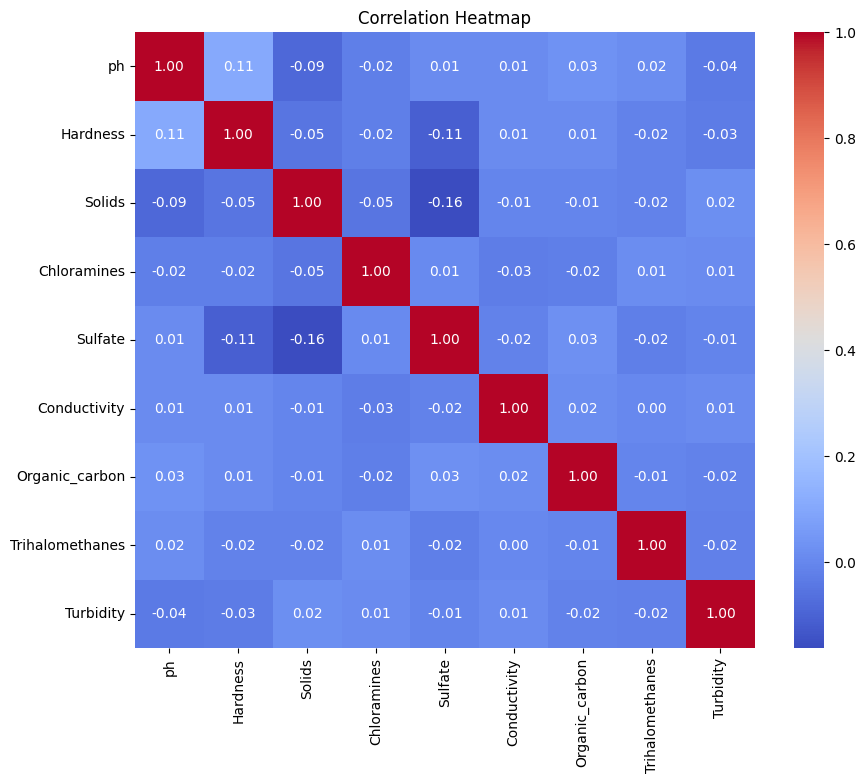

In [ ]:
# Bước 1: Chuyển đổi PySpark DataFrame thành Pandas DataFrame
pandas_df = df_dropped.toPandas()

# Bước 2: Lọc các cột số
numeric_df = pandas_df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon','Trihalomethanes','Turbidity']]

# Bước 3: Tạo heatmap cho các cột đã chọn
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# Chuyển đổi các cột thành vector đặc trưng
assembler = VectorAssembler(inputCols=[column for column in df_dropped.columns if column != 'Potability'], outputCol="features")
data = assembler.transform(df_dropped)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train, test = data.randomSplit([0.7, 0.3], seed=42)


Logistic Regression

In [ ]:
# Khởi tạo mô hình Logistic Regression
lr = LogisticRegression(labelCol="Potability", featuresCol="features")

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
lr_model = lr.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập dữ liệu kiểm tra
lr_predictions = lr_model.transform(test)

# Hiển thị một số kết quả dự đoán
lr_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.61604256157384...|
|         0|       0.0|[0.60879477945195...|
|         0|       0.0|[0.61821207667206...|
|         0|       0.0|[0.55681548586321...|
|         1|       0.0|[0.68176174059191...|
|         0|       0.0|[0.57630127314571...|
|         0|       0.0|[0.60787573529029...|
|         0|       0.0|[0.59358759972538...|
|         0|       0.0|[0.58983567013995...|
|         0|       0.0|[0.62271572042265...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print(f"Accuracy of the model: {accuracy}")


Accuracy of the model: 0.5967741935483871


Random Forest

In [ ]:
# Khởi tạo mô hình Random Forest
rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
rf_model = rf.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập kiểm tra
rf_predictions = rf_model.transform(test)

# Hiển thị một số kết quả dự đoán
rf_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.65944947388928...|
|         0|       0.0|[0.75206791415151...|
|         0|       0.0|[0.73661542229404...|
|         0|       0.0|[0.58878699006281...|
|         1|       1.0|[0.37311190378025...|
|         0|       0.0|[0.77266433516079...|
|         0|       0.0|[0.75883637409502...|
|         0|       0.0|[0.74654253234438...|
|         0|       0.0|[0.77177554272416...|
|         0|       0.0|[0.68608554337719...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Accuracy of the Random Forest model: {rf_accuracy}")


Accuracy of the Random Forest model: 0.6684587813620072


Decision Tree Classifier

In [ ]:
# Khởi tạo mô hình Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Potability", featuresCol="features")

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
dt_model = dt.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập kiểm tra
dt_predictions = dt_model.transform(test)

# Hiển thị một số kết quả dự đoán
dt_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.62162162162162...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       1.0|           [0.0,1.0]|
|         1|       1.0|[0.06976744186046...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.67391304347826...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
dt_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print(f"Accuracy of the Decision Tree model: {dt_accuracy}")


Accuracy of the Decision Tree model: 0.6541218637992832


In [ ]:
# Khởi tạo bộ đánh giá
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")

# Tính toán độ chính xác
accuracy_dict = {}
# Pass the logistic regression predictions DataFrame (assuming you have it as 'lr_predictions')
accuracy_dict["Logistic Regression"] = evaluator.evaluate(lr_predictions)
accuracy_dict["Random Forest"] = evaluator.evaluate(rf_predictions)
accuracy_dict["Decision Tree"] = evaluator.evaluate(dt_predictions)


for model, accuracy in accuracy_dict.items():
    print(f"Accuracy of {model}: {accuracy}")

Accuracy of Logistic Regression: 0.5967741935483871
Accuracy of Random Forest: 0.6684587813620072
Accuracy of Decision Tree: 0.6541218637992832


<ipython-input-23-a940451938fc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="deep")


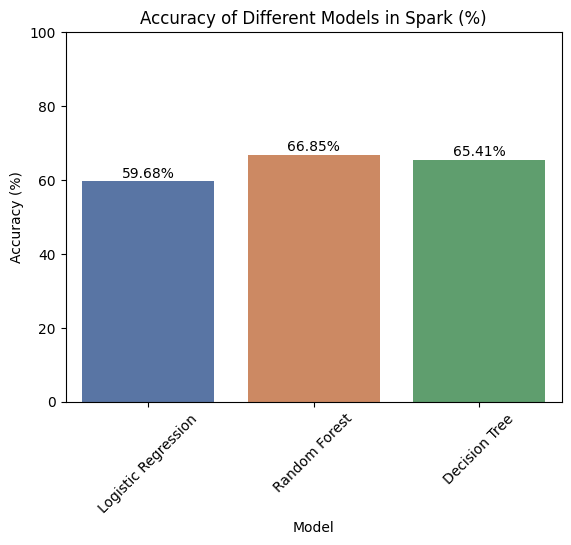

In [ ]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Convert accuracy values to percentage
accuracy_dict = {k: v * 100 for k, v in accuracy_dict.items()}

# Create a DataFrame from the accuracy dictionary
accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['Model', 'Accuracy'])

# Plot the accuracy comparison
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="deep")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits between 0 and 100

# Display accuracy values on top of each bar
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", color='black', ha="center")

plt.title("Accuracy of Different Models in Spark (%)")
plt.ylabel("Accuracy (%)")
plt.show()


TRỰC QUAN HOÁ DỮ LIỆU

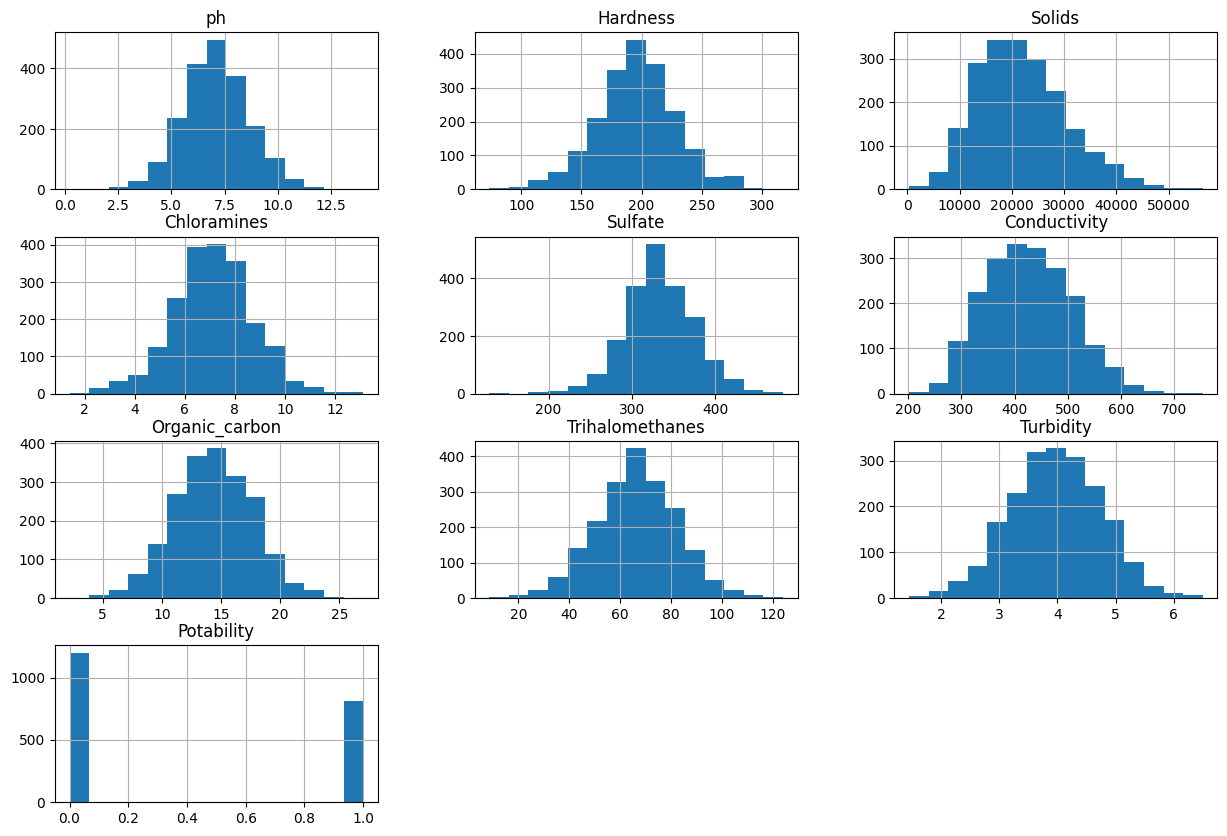

In [ ]:
pandas_df = df_dropped.toPandas()

# Vẽ biểu đồ histogram bằng Pandas
pandas_df.hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.show()

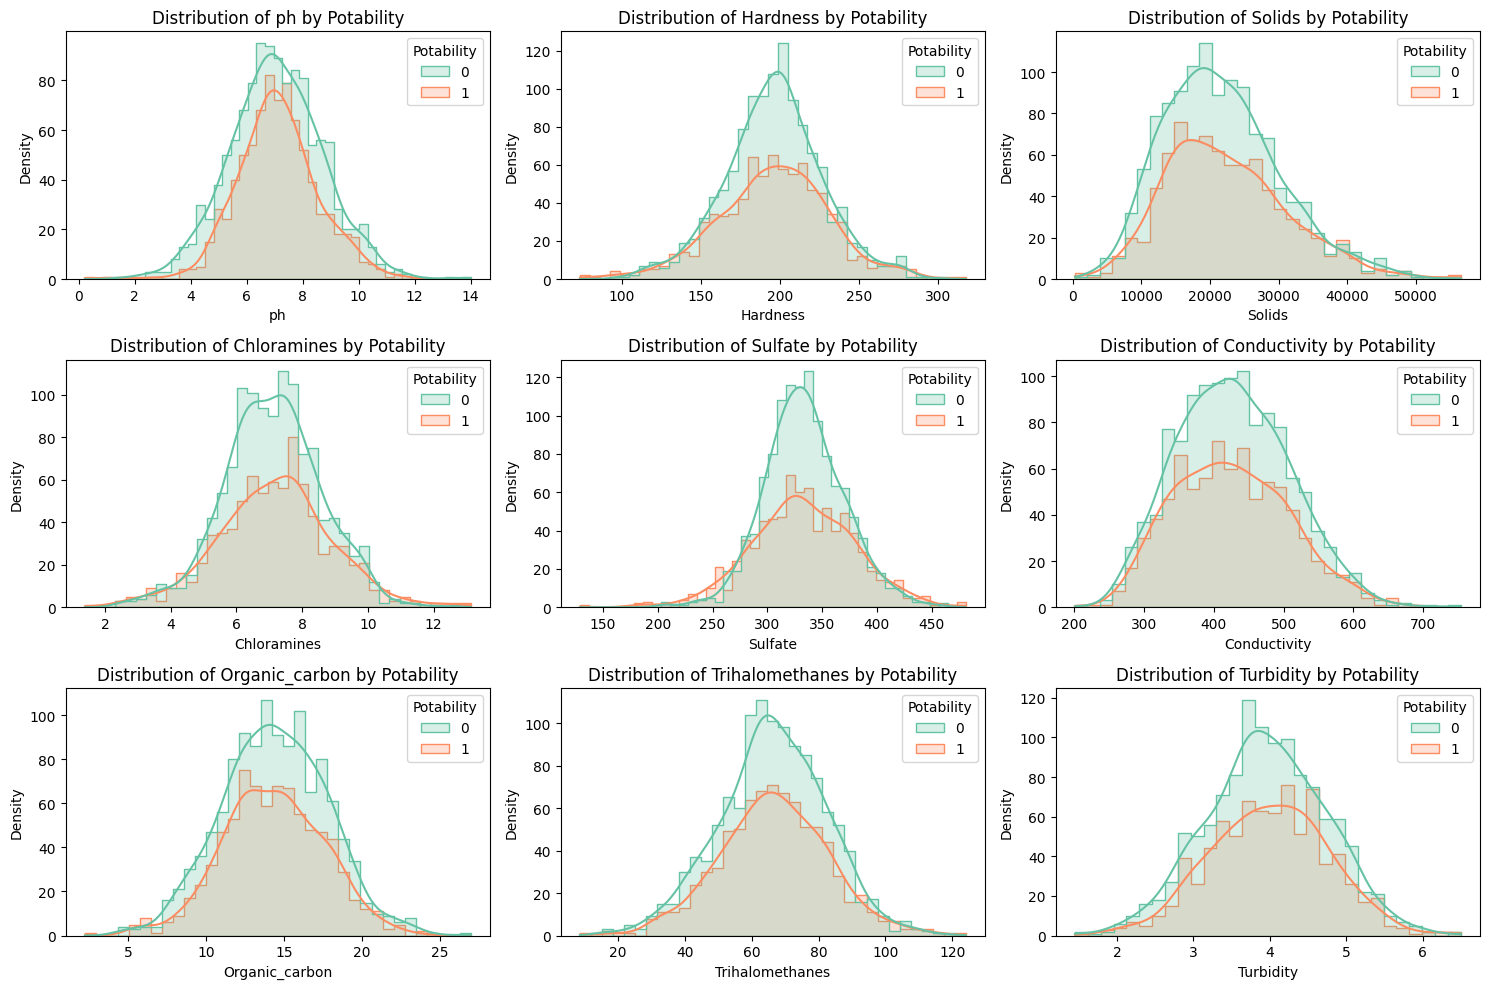

In [ ]:
plt.figure(figsize=(15, 10))

# Define the 'variables' list here
variables = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Convert the Spark DataFrame 'df_dropped' to a Pandas DataFrame
df_dropped_pd = df_dropped.toPandas() # Add this line to define df_dropped_pd

for i, var in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df_dropped_pd, x=var, hue='Potability', kde=True, element="step", palette="Set2")
    plt.title(f'Distribution of {var} by Potability')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

Trực quan theo độ pH

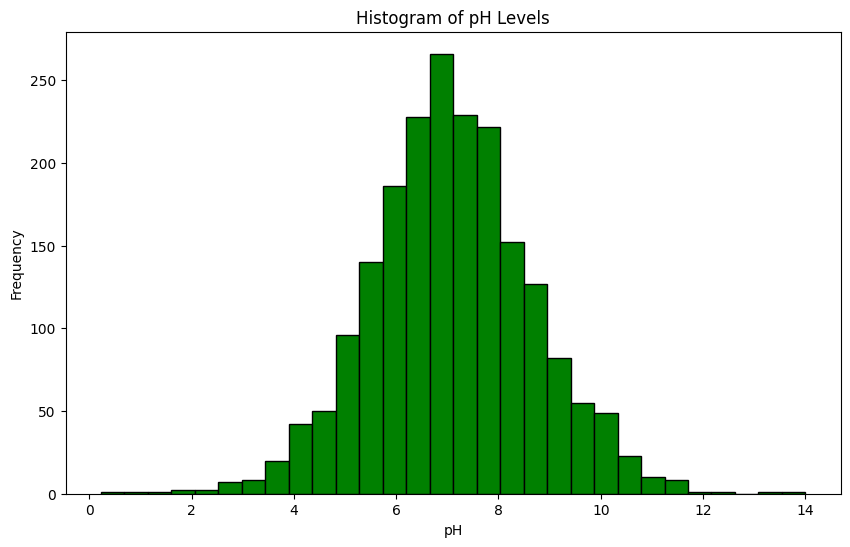

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['ph'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of pH Levels')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.show()


Trực quan độ pH ảnh hưởng đến độ an toàn của nước

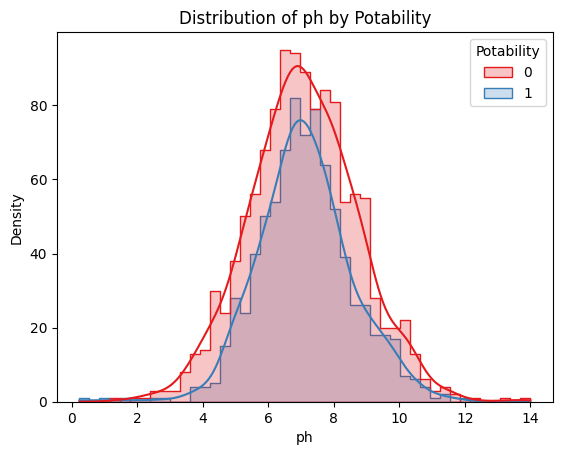

In [ ]:
sns.histplot(data=df_dropped_pd, x='ph', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of ph by Potability')
plt.xlabel('ph')
plt.ylabel('Density')
plt.show()


Biểu đồ cho thấy sự phân bố độ pH của hai nhóm nước uống: an toàn (Potability = 1) và không an toàn (Potability = 0).
*   Nước không an toàn (màu đỏ): Phân bố trải rộng từ pH 5 đến 9, với đỉnh ở khoảng pH 7, cho thấy nước không an toàn có thể có pH khá biến động.
*   Nước an toàn (màu xanh): Phân bố tập trung hơn trong khoảng pH 6 đến 8, cũng với đỉnh ở pH 7, nhưng mật độ thấp hơn so với nước không an toàn ở hầu hết các giá trị pH.
*   So sánh: Mức pH từ 6 đến 8 có sự chồng lấn giữa hai nhóm, nhưng nước không an toàn thường có pH nằm ngoài khoảng này


--> Nhìn chung, pH là một yếu tố quan trọng trong việc xác định độ an toàn của nước uống, nhưng không phải là yếu tố duy nhất.


Trực quan theo độ Hardness

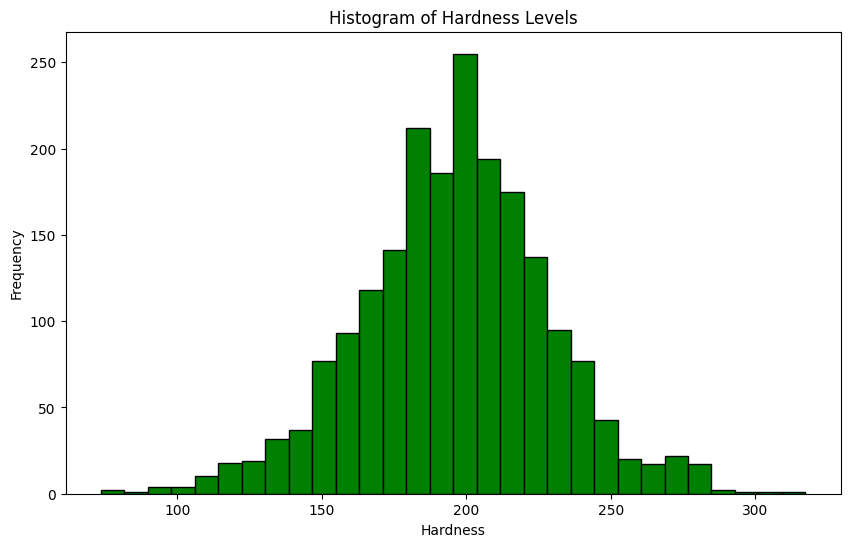

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Hardness'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Hardness Levels')
plt.xlabel('Hardness')
plt.ylabel('Frequency')
plt.show()


Trực quan độ Hardness ảnh hưởng đến độ an toàn của nước

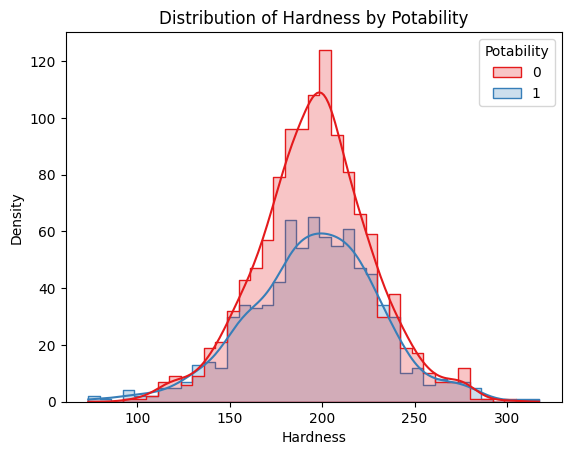

In [ ]:
sns.histplot(data=df_dropped_pd, x='Hardness', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Hardness by Potability')
plt.xlabel('Hardness')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố độ cứng nước (Hardness) theo hai nhóm: nước uống được (Potability = 1, màu xanh) và nước không uống được (Potability = 0, màu đỏ).
*   Nước không uống được (màu đỏ): Đỉnh phân bố cao nhất nằm ở khoảng 200, với phần lớn các mẫu nằm trong khoảng 150-250. Phân bố này rộng hơn, cho thấy sự đa dạng về độ cứng trong nước không uống được.
*   Nước uống được (màu xanh): Đỉnh phân bố thấp hơn, cũng tập trung quanh mức 200. Phân bố này hẹp hơn, cho thấy độ cứng nước uống được thường ổn định hơn trong khoảng 150-250.


--> Nhận xét: Có sự chồng lấn, nhưng nước không uống được có phân bố rộng hơn, đặc biệt ở các giá trị cực đoan, ngụ ý độ cứng quá cao hoặc quá thấp thường không an toàn.


Trực quan theo Solids

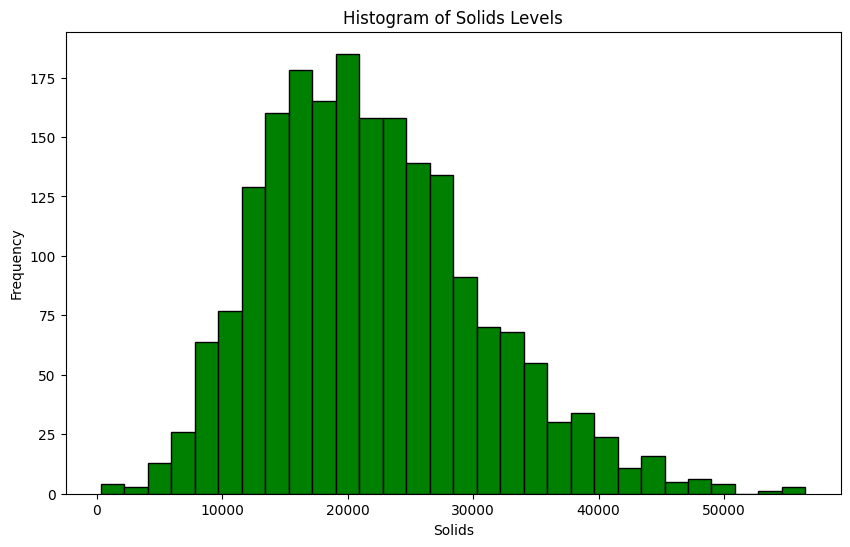

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Solids'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Solids Levels')
plt.xlabel('Solids')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Solids ảnh hưởng đến độ an toàn của nước

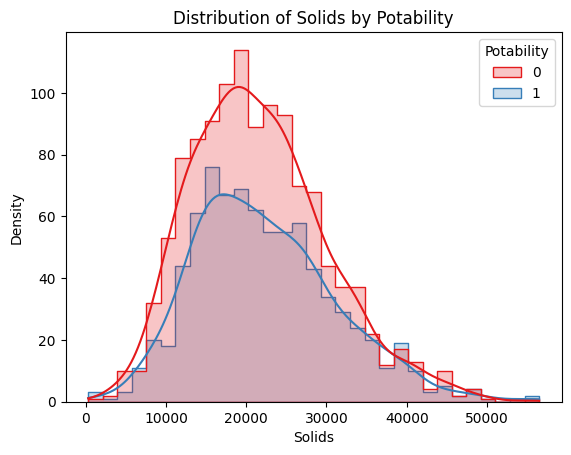

In [ ]:
sns.histplot(data=df_dropped_pd, x='Solids', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Solids by Potability')
plt.xlabel('Solids')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố hàm lượng chất rắn giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Tập trung quanh 20,000 mg/L với mật độ cao hơn trong khoảng 10,000-30,000 mg/L..
*   Nước uống được: Cũng tập trung quanh 20,000 mg/L, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước có hàm lượng chất rắn cao hơn thường không an toàn để uống.

Trực quan theo Chloramines

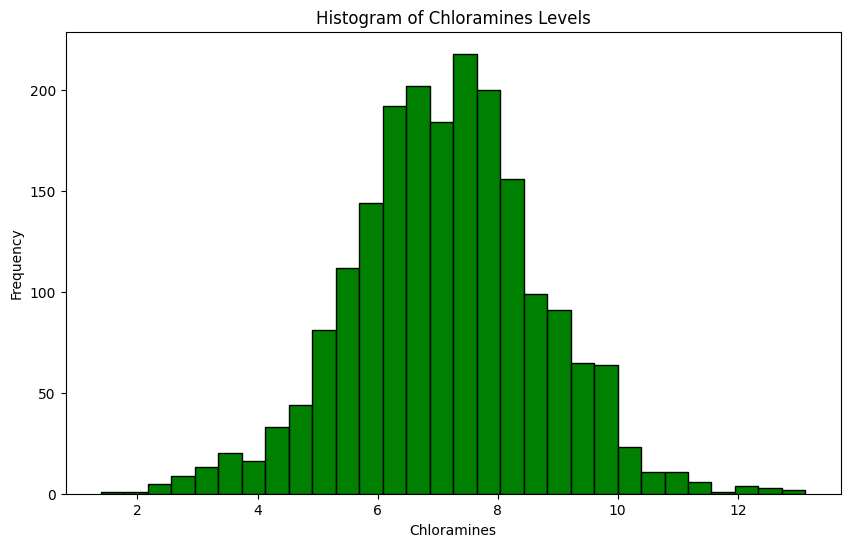

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Chloramines'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Chloramines Levels')
plt.xlabel('Chloramines')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Chloramines ảnh hưởng đến độ an toàn của nước

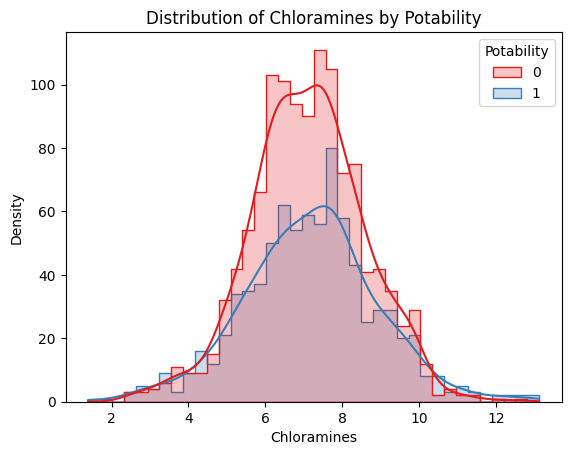

In [ ]:
sns.histplot(data=df_dropped_pd, x='Chloramines', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Chloramines by Potability')
plt.xlabel('Chloramines')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức Chloramines giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Nước không uống được: Mật độ cao nhất tập trung quanh mức 7-8 mg/L, với phân bố rộng hơn.
*   Nước uống được:Tập trung chủ yếu từ 6-8 mg/L, nhưng với mật độ thấp hơn và phân bố hẹp hơn.

--> Nhận xét: Nước không uống được có xu hướng xuất hiện ở cả hai phía của khoảng 6-8 mg/L với mật độ cao hơn, cho thấy mức Chloramines cao hoặc thấp đều có thể liên quan đến nước không an toàn.

Trực quan theo Sulfate

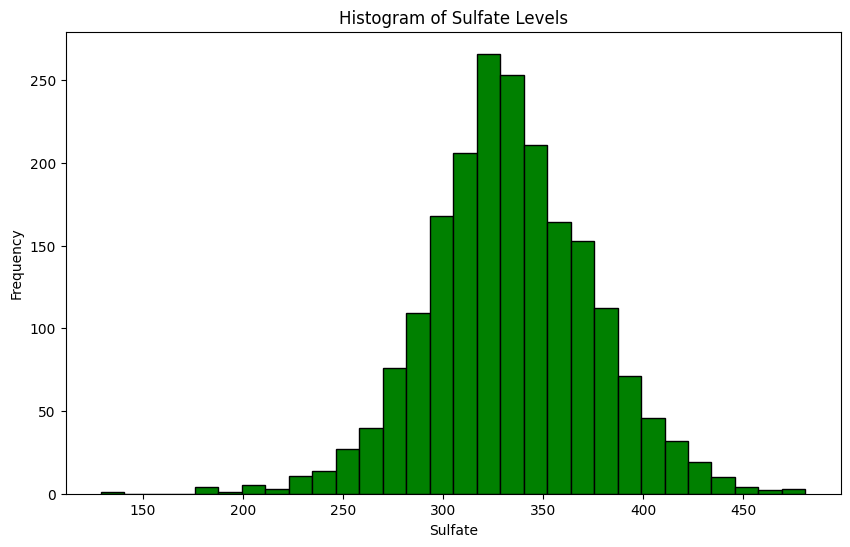

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Sulfate'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Sulfate Levels')
plt.xlabel('Sulfate')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Sulfate ảnh hưởng đến độ an toàn của nước

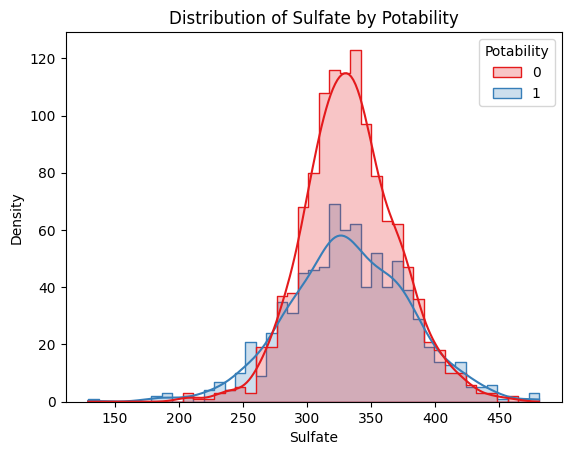

In [ ]:
sns.histplot(data=df_dropped_pd, x='Sulfate', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Sulfate by Potability')
plt.xlabel('Sulfate')
plt.ylabel('Density')
plt.show()


Biểu đồ này thể hiện sự phân bố mức Sulfate giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Mật độ cao nhất tập trung quanh mức 325 mg/L, với phân bố rộng hơn.
*   Nước uống được: Tập trung chủ yếu ở khoảng 300-350 mg/L, nhưng mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được có mật độ cao hơn ở các giá trị Sulfate từ 300-350 mg/L, cho thấy mức Sulfate cao hơn có thể liên quan đến nước không an toàn.

Trực quan theo Conductivity

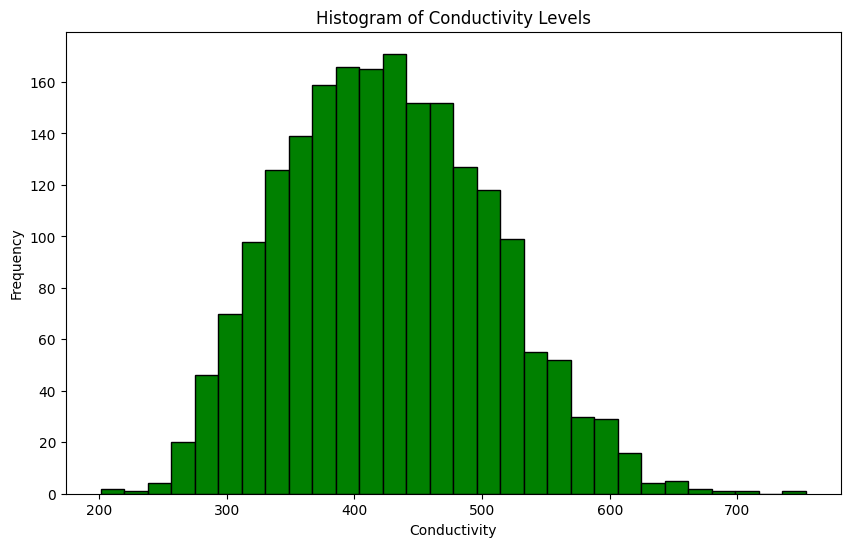

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Conductivity'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Conductivity Levels')
plt.xlabel('Conductivity')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Conductivity ảnh hưởng đến độ an toàn của nước

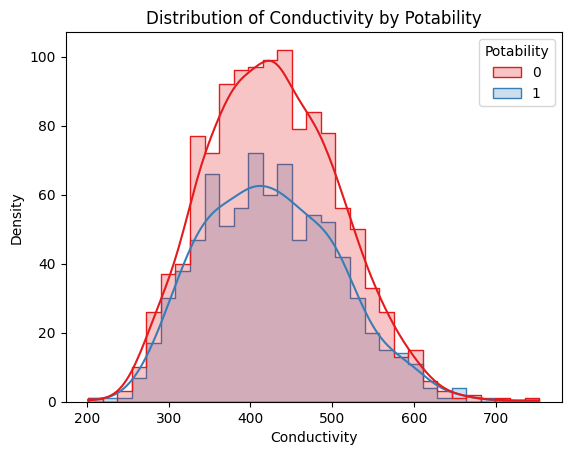

In [ ]:
sns.histplot(data=df_dropped_pd, x='Conductivity', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Conductivity by Potability')
plt.xlabel('Conductivity')
plt.ylabel('Density')
plt.show()


Biểu đồ này thể hiện sự phân bố độ dẫn điện (Conductivity) của nước giữa hai nhóm: nước uống được (màu xanh) và nước không uống được (màu đỏ).
*   Nước không uống được: Tập trung nhiều quanh mức 400-450 µS/cm, với phân bố rộng hơn.
*   Nước uống được: Tập trung chủ yếu từ 350-500 µS/cm, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có độ dẫn điện cao hơn, đặc biệt trong khoảng 400-450 µS/cm, cho thấy mức độ dẫn điện cao có thể liên quan đến nước không an toàn.

Trực quan theo Organic_carbon

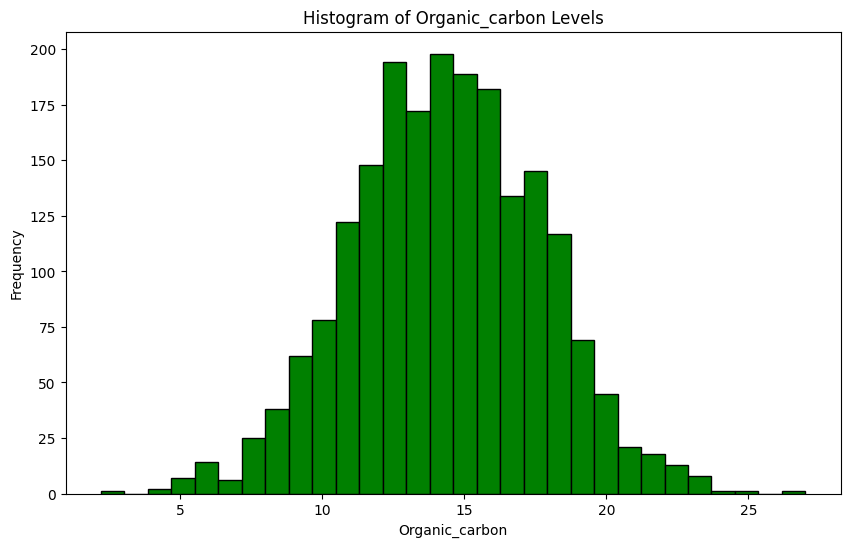

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Organic_carbon'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Organic_carbon Levels')
plt.xlabel('Organic_carbon')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Organic_carbon ảnh hưởng đến độ an toàn của nước

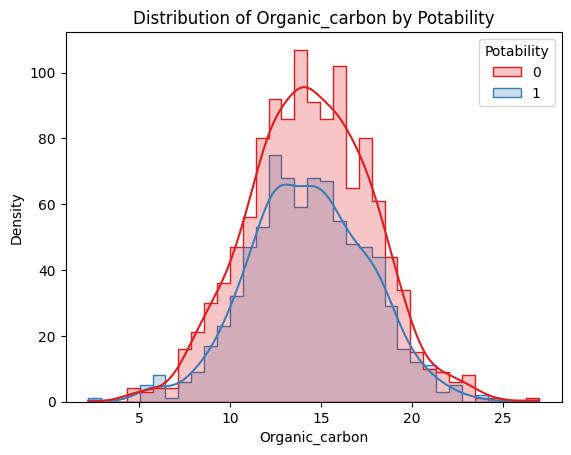

In [ ]:
sns.histplot(data=df_dropped_pd, x='Organic_carbon', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Organic_carbon by Potability')
plt.xlabel('Organic_carbon')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ carbon hữu cơ (Organic Carbon) giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Tập trung chủ yếu quanh mức 15 mg/L, với phân bố rộng hơn.
*   Nước uống được: Cũng tập trung ở khoảng 15 mg/L, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức độ carbon hữu cơ cao hơn, đặc biệt trong khoảng 10-20 mg/L, cho thấy mức carbon hữu cơ cao có thể liên quan đến nước không an toàn.

Trực quan theo Trihalomethanes

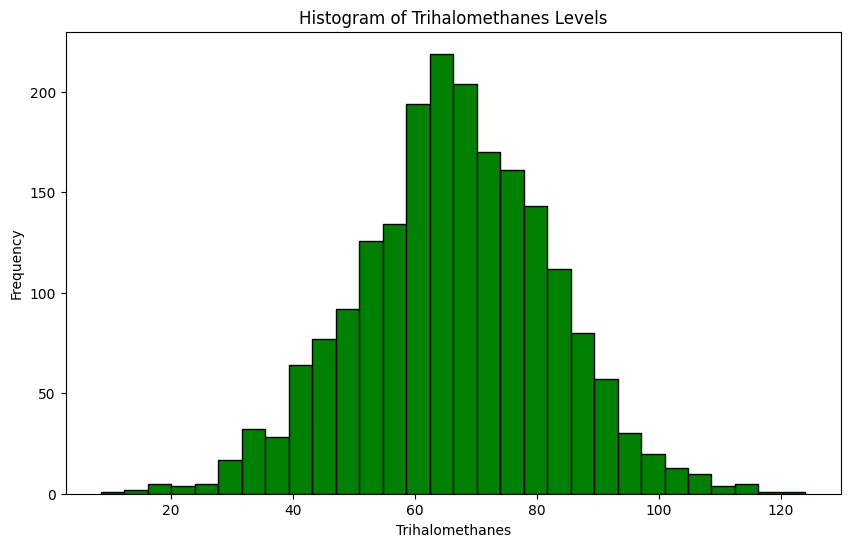

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Trihalomethanes'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Trihalomethanes Levels')
plt.xlabel('Trihalomethanes')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Trihalomethanes ảnh hưởng đến độ an toàn của nước

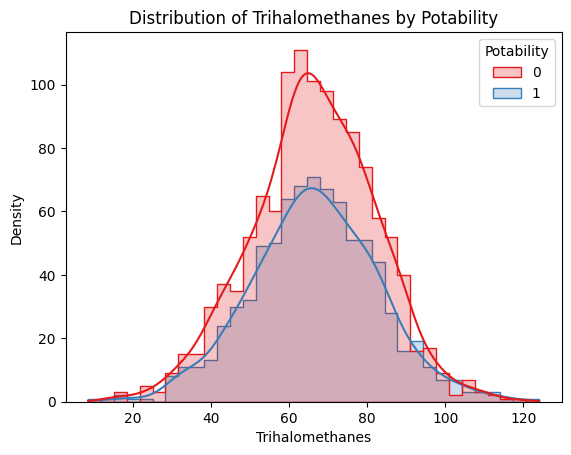

In [ ]:
sns.histplot(data=df_dropped_pd, x='Trihalomethanes', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Trihalomethanes by Potability')
plt.xlabel('Trihalomethanes')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ Trihalomethanes giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Tập trung nhiều nhất quanh mức 60 µg/L, với phân bố rộng hơn.
*   Nước uống được: Tập trung chủ yếu trong khoảng 50-70 µg/L, nhưng mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức Trihalomethanes cao hơn, đặc biệt quanh mức 60 µg/L, cho thấy mức Trihalomethanes cao có thể liên quan đến nước không an toàn.

Trực quan theo Turbidity

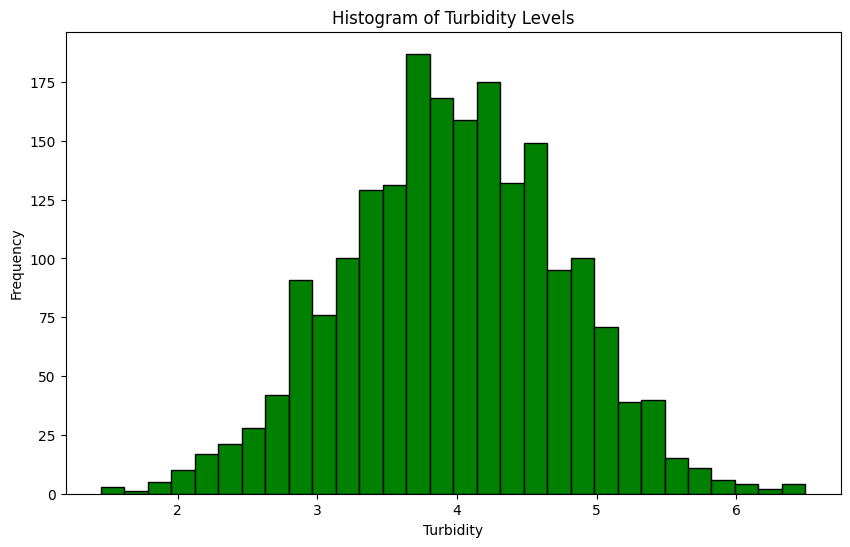

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Turbidity'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Turbidity Levels')
plt.xlabel('Turbidity')
plt.ylabel('Frequency')
plt.show()


Trực quan theo Turbidity ảnh hưởng đến độ an toàn của nước

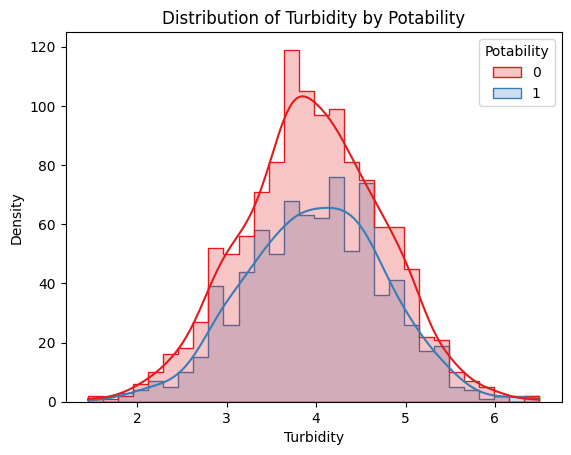

In [ ]:
sns.histplot(data=df_dropped_pd, x='Turbidity', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Turbidity by Potability')
plt.xlabel('Turbidity')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ đục (Turbidity) giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Mật độ cao nhất tập trung quanh mức 4 NTU, với phân bố rộng hơn.
*   Nước uống được: Cũng tập trung quanh mức 4 NTU, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức độ đục cao hơn, đặc biệt quanh mức 4 NTU, cho thấy mức độ đục cao có thể liên quan đến nước không an toàn.